In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix
from xgboost import XGBClassifier
import joblib
import time
from imblearn.over_sampling import SMOTE

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Define all functions directly in the notebook
def create_preprocessor():
    """
    Create a preprocessing pipeline
    """
    # Define numeric and categorical features
    numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                       'oldbalanceDest', 'newbalanceDest']
    categorical_features = ['type']
    
    # Create preprocessing transformers
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

def load_and_preprocess_data(filepath, sampling_method=None):
    """
    Load and preprocess the transaction data
    """
    # Load data
    df = pd.read_csv(filepath)
    
    # Remove leakage columns and identifiers
    df = df.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, errors='ignore')
    
    # Separate features and target
    X = df.drop('isFraud', axis=1)
    y = df['isFraud']
    
    # Create and fit preprocessor
    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X)
    
    # Apply resampling if specified
    if sampling_method == 'smote':
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_processed, y)
        return X_resampled, y_resampled, preprocessor
    
    return X_processed, y, preprocessor

def _calculate_confusion_matrix(y_true, y_pred):
    """Calculate confusion matrix components"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn, fp, fn, tp

def _calculate_business_impact(fp, fn):
    """
    Calculate business impact based on the problem statement
    False positives cost 5x more than false negatives
    """
    false_negative_cost = fn * 1  # Base cost of $1 for false negatives
    false_positive_cost = fp * 5  # 5x more expensive
    return false_negative_cost + false_positive_cost

def train_models_simple(X, y, test_size=0.2, random_state=42):
    """
    Train and compare multiple models (simplified version without parallel processing)
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Define models with simpler parameter grids
    models = {
        'LogisticRegression': LogisticRegression(
            random_state=random_state, 
            class_weight='balanced',
            C=0.1,
            solver='liblinear'
        ),
        'RandomForest': RandomForestClassifier(
            random_state=random_state, 
            class_weight='balanced',
            n_estimators=100,
            max_depth=10
        ),
        'XGBoost': XGBClassifier(
            random_state=random_state, 
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate precision-recall AUC
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        
        # Calculate business impact
        tn, fp, fn, tp = _calculate_confusion_matrix(y_test, y_pred)
        business_impact = _calculate_business_impact(fp, fn)
        
        # Store results
        results[name] = {
            'model': model,
            'pr_auc': pr_auc,
            'business_impact': business_impact,
            'training_time': time.time() - start_time,
            'confusion_matrix': (tn, fp, fn, tp)
        }
        
        print(f"{name} completed in {time.time() - start_time:.2f} seconds")
        print(f"Precision-Recall AUC: {pr_auc:.4f}")
        print(f"Business impact: ${business_impact:,.2f}")
        print("-" * 50)
    
    return results, X_test, y_test

def select_best_model(results):
    """Select the best model based on multiple criteria"""
    best_score = -float('inf')
    best_model_name = None
    
    for name, result in results.items():
        # Combined score (weighted average of PR AUC and inverse business impact)
        max_impact = max(r['business_impact'] for r in results.values())
        normalized_impact = 1 - (result['business_impact'] / max_impact)
        combined_score = 0.7 * result['pr_auc'] + 0.3 * normalized_impact
        
        if combined_score > best_score:
            best_score = combined_score
            best_model_name = name
    
    return best_model_name, results[best_model_name]

def save_model(model, filename):
    """Save the model to a file"""
    joblib.dump(model, filename)

print("✅ All functions defined successfully!")

✅ All functions defined successfully!


In [4]:
# Load the data
df = pd.read_csv('data/Transactions.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (1048575, 11)

Column names:
['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

First few rows:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check class distribution
fraud_percentage = df['isFraud'].mean() * 100
print(f"\nFraud percentage: {fraud_percentage:.4f}%")
print("Class distribution:")
print(df['isFraud'].value_counts())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud percentage: 0.1089%
Class distribution:
isFraud
0    1047433
1       1142
Name: count, dtype: int64


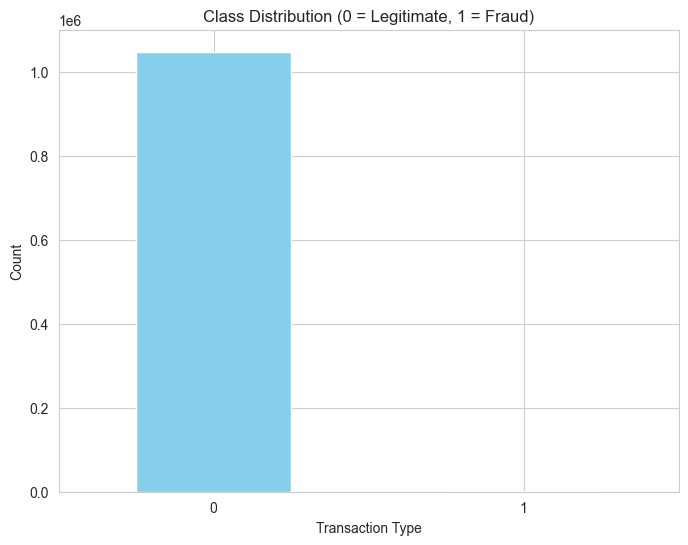

In [6]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
df['isFraud'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (0 = Legitimate, 1 = Fraud)')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Preprocess the data (using a smaller sample if needed)
try:
    X_processed, y_processed, preprocessor = load_and_preprocess_data('data/Transactions.csv', 'smote')
    print(f"Processed dataset shape: {X_processed.shape}")
    print(f"Processed class distribution: {np.bincount(y_processed)}")
except MemoryError:
    print("Memory error - using smaller sample...")
    # Use a smaller sample if memory is an issue
    df_sample = pd.read_csv('data/transactions.csv').sample(frac=0.3, random_state=42)
    X_sample = df_sample.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1, errors='ignore')
    y_sample = df_sample['isFraud']
    
    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X_sample)
    
    # Apply SMOTE
    sampler = SMOTE(random_state=42)
    X_processed, y_processed = sampler.fit_resample(X_processed, y_sample)
    
    print(f"Processed dataset shape: {X_processed.shape}")
    print(f"Processed class distribution: {np.bincount(y_processed)}")

Processed dataset shape: (2094866, 10)
Processed class distribution: [1047433 1047433]


In [8]:
# Compare models (using simplified version)
results, X_test_processed, y_test_processed = train_models_simple(X_processed, y_processed)

Training LogisticRegression...
LogisticRegression completed in 11.20 seconds
Precision-Recall AUC: 0.9894
Business impact: $80,191.00
--------------------------------------------------
Training RandomForest...
RandomForest completed in 465.01 seconds
Precision-Recall AUC: 0.9992
Business impact: $23,698.00
--------------------------------------------------
Training XGBoost...
XGBoost completed in 12.81 seconds
Precision-Recall AUC: 0.9994
Business impact: $15,513.00
--------------------------------------------------


In [9]:
# Display results
results_df = pd.DataFrame({
    'Model': [],
    'PR AUC': [],
    'Business Impact': [],
    'Training Time (s)': []
})

for name, result in results.items():
    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': [name],
        'PR AUC': [result['pr_auc']],
        'Business Impact': [result['business_impact']],
        'Training Time (s)': [result['training_time']]
    })], ignore_index=True)

print("Model Comparison Results:")
display(results_df.sort_values('PR AUC', ascending=False))

Model Comparison Results:


,Model,PR AUC,Business Impact,Training Time (s)
2,XGBoost,0.999423,15513.0,12.814055
1,RandomForest,0.999211,23698.0,465.012109
0,LogisticRegression,0.989419,80191.0,11.198101


In [10]:
# Select the best model
best_model_name, best_model_info = select_best_model(results)
print(f"Best model: {best_model_name}")
print(f"Precision-Recall AUC: {best_model_info['pr_auc']:.4f}")
print(f"Business impact: ${best_model_info['business_impact']:,.2f}")

# Save the best model
save_model(best_model_info['model'], 'models/fraud_model.pkl')
print("Model saved to models/fraud_model.pkl")

Best model: XGBoost
Precision-Recall AUC: 0.9994
Business impact: $15,513.00
Model saved to models/fraud_model.pkl


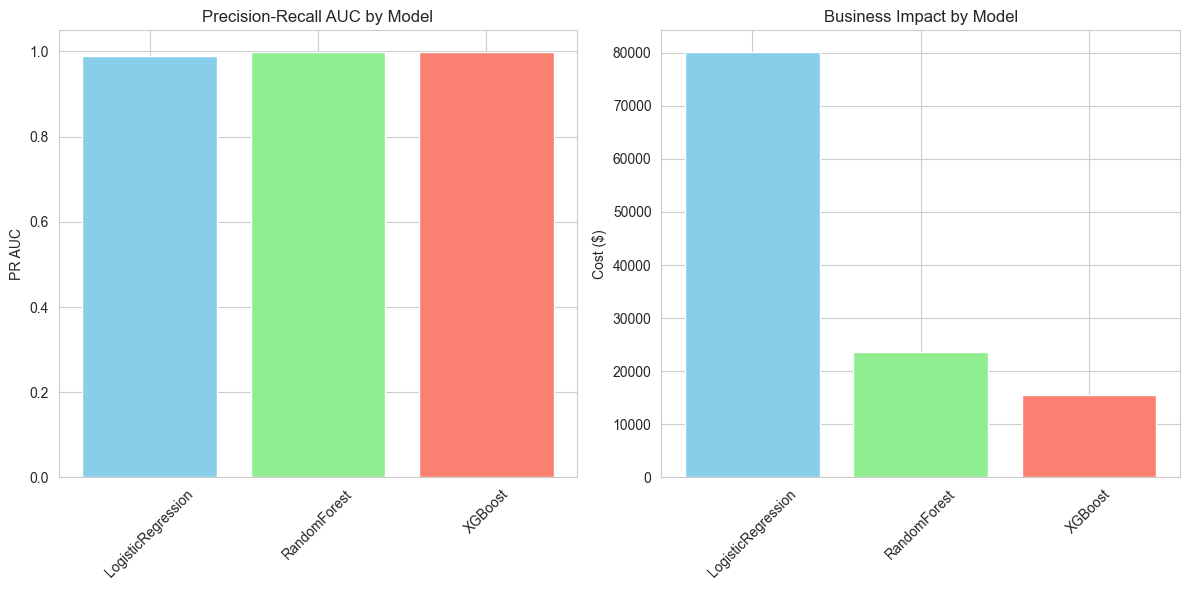

In [11]:
# Create performance comparison plot
plt.figure(figsize=(12, 6))

# PR AUC comparison
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['PR AUC'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Precision-Recall AUC by Model')
plt.ylabel('PR AUC')
plt.xticks(rotation=45)

# Business impact comparison
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['Business Impact'], color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Business Impact by Model')
plt.ylabel('Cost ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# Display confusion matrix values
print("Confusion Matrix Values:")
print("========================")
for name, result in results.items():
    tn, fp, fn, tp = result['confusion_matrix']
    print(f"\n{name}:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

Confusion Matrix Values:

LogisticRegression:
True Negatives: 194344
False Positives: 15143
False Negatives: 4476
True Positives: 205011

RandomForest:
True Negatives: 205131
False Positives: 4356
False Negatives: 1918
True Positives: 207569

XGBoost:
True Negatives: 206788
False Positives: 2699
False Negatives: 2018
True Positives: 207469


In [13]:
# Final summary
print("Fraud Detection Analysis Summary")
print("================================")
print(f"Best Model: {best_model_name}")
print(f"Precision-Recall AUC: {best_model_info['pr_auc']:.4f}")
print(f"Business Impact: ${best_model_info['business_impact']:,.2f}")
print(f"Fraud Detection Rate: {best_model_info['confusion_matrix'][3] / (best_model_info['confusion_matrix'][3] + best_model_info['confusion_matrix'][2]):.2%}")

# Calculate cost savings compared to no model
no_model_cost = len(y_test_processed) * 5  # If we blocked all transactions
cost_savings = no_model_cost - best_model_info['business_impact']
print(f"Cost Savings Compared to Blocking All Transactions: ${cost_savings:,.2f}")

Fraud Detection Analysis Summary
Best Model: XGBoost
Precision-Recall AUC: 0.9994
Business Impact: $15,513.00
Fraud Detection Rate: 99.04%
Cost Savings Compared to Blocking All Transactions: $2,079,357.00


In [14]:
# Explain why a 99.9% accurate model would be useless
print("""
Why a 99.9% Accurate Model Would Be Useless in Fraud Detection:
================================================================

In fraud detection with extreme class imbalance (only 0.2% fraudulent transactions), 
a model that achieves 99.9% accuracy would be useless because:

1. A model that simply predicts "not fraud" for all transactions would achieve ~99.8% 
   accuracy but catch 0% of actual fraud.

2. Accuracy doesn't account for the asymmetric business costs: false positives 
   (blocking legitimate transactions) cost 5x more than false negatives (missing fraud).

3. Precision and recall are much more informative metrics for imbalanced classification problems.

Scikit-learn helps avoid this pitfall through:
- Class weighting options (class_weight='balanced')
- Appropriate scoring metrics (precision_recall_auc)
- Resampling techniques (SMOTE, NearMiss)
- Cost-sensitive learning approaches
""")


Why a 99.9% Accurate Model Would Be Useless in Fraud Detection:

In fraud detection with extreme class imbalance (only 0.2% fraudulent transactions), 
a model that achieves 99.9% accuracy would be useless because:

1. A model that simply predicts "not fraud" for all transactions would achieve ~99.8% 
   accuracy but catch 0% of actual fraud.

2. Accuracy doesn't account for the asymmetric business costs: false positives 
   (blocking legitimate transactions) cost 5x more than false negatives (missing fraud).

3. Precision and recall are much more informative metrics for imbalanced classification problems.

Scikit-learn helps avoid this pitfall through:
- Class weighting options (class_weight='balanced')
- Appropriate scoring metrics (precision_recall_auc)
- Resampling techniques (SMOTE, NearMiss)
- Cost-sensitive learning approaches

